# Analyze EEG data

This notebook will help you prepare the figures for your EEG lab report. To run this, you should export a .txt file of 30 seconds of data of either eyes open or closed. Change the filename below. 

In [15]:
import numpy as np

#Change the filename to EXACTLY match your file
filename = 'Data/EEG_Trial1_EyesClosed.txt'
sampling_freq = 400

# Define column names
columns = ['time', 'recording']

# Use numpy genfromtxt to import
data = np.genfromtxt(filename, dtype=float, skip_header=6, delimiter='\t', names=columns, encoding = 'unicode_escape')
timestamps = data['time']
recording = data['recording']
recording

array([-125.95   , -124.95   , -139.2875 , ...,   69.21875,   63.8625 ,
         59.76875])

Now, we can plot the data!

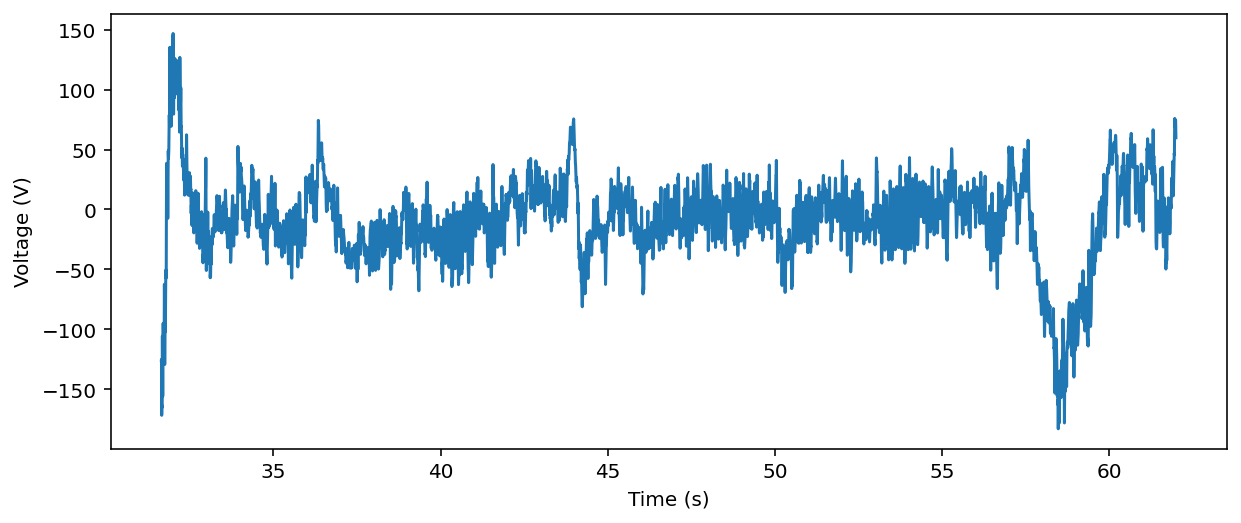

In [16]:
# import plotting packages
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

# set up figure & plt
fig,ax = plt.subplots(figsize=(10,4))

plt.plot(timestamps,recording)

# You may need to change the x label
plt.xlabel('Time (s)') 

# You may need to change the y label
plt.ylabel('Voltage (V)') 

# This makes the axis labels print without scientific notation
ax.ticklabel_format(useOffset=False, style='plain') 

# You can uncomment the line below to restrict the x axis plotting -- for example, to Zoom into alpha waves
#plt.xlim([200,700])

plt.show()

## Apply a bandpass filter to our signal (optional demonstration)

Below, we'll compute a bandpass by first applying a _low-pass filter_, followed by a _high-pass filter_ (or vice versa). This is simply demonstration of how this works.

Signal filtration is usually accomplished in 2 steps
1. Design a _filter kernel_
2. Apply the filter kernel to the data
    
We will use a **Butterworth** filter. The ideal filter would _completely_ pass everything in the passband (i.e., allow through the parts of the signal we care about) and completely reject everything outside of it, but this cannot be achieved in reality—the Butterworth filter is a close approximation.

We design the filter in Python using `scipy`'s `signal.butter` function, with three arguments:
1. The _filter order_ (we'll use a 4th order filter)
2. The _filter frequency_ (we must adjust for the sampling frequency, `f_s`, which is 1000 Hz for these data, i.e. 1000 data points were recorded per second)
3. The type of filter (`'lowpass'` or `'highpass'`)

It returns 2 filter parameters, `a` and `b`. Then, the bandpass filter is applied using `signal.filtfilt`, which takes as its parameters `b`, `a`, and the signal to be processed

Below, an example bandpass computation is shown to extract the _alpha_ rhythm from the channel 1 data, the results are stored in a dictionary called `oscillations_filtered`, with the oscillation name (e.g. `'alpha'`) as the key

In [47]:
from scipy import signal

# Define lower and upper limits of our bandpass
# What happens if you make this alpha?
filter_limits = [0.5, 4]

# First, apply a lowpass filter
b, a = signal.butter(4, (filter_limits[1]/ (sampling_freq / 2)), 'lowpass') # Design filter with high filter limit
lowpassed = signal.filtfilt(b, a, recording) # Apply it forwards and backwards (filtfilt)

# Then, apply a high pass filter
b, a = signal.butter(4, (filter_limits[0] / (sampling_freq / 2)), 'highpass') # Design filter with low filter limit
bandpassed = signal.filtfilt(b, a, lowpassed) # Apply it

print('Data filtered!')

Data filtered!


Now, let's plot our original and bandpassed data.

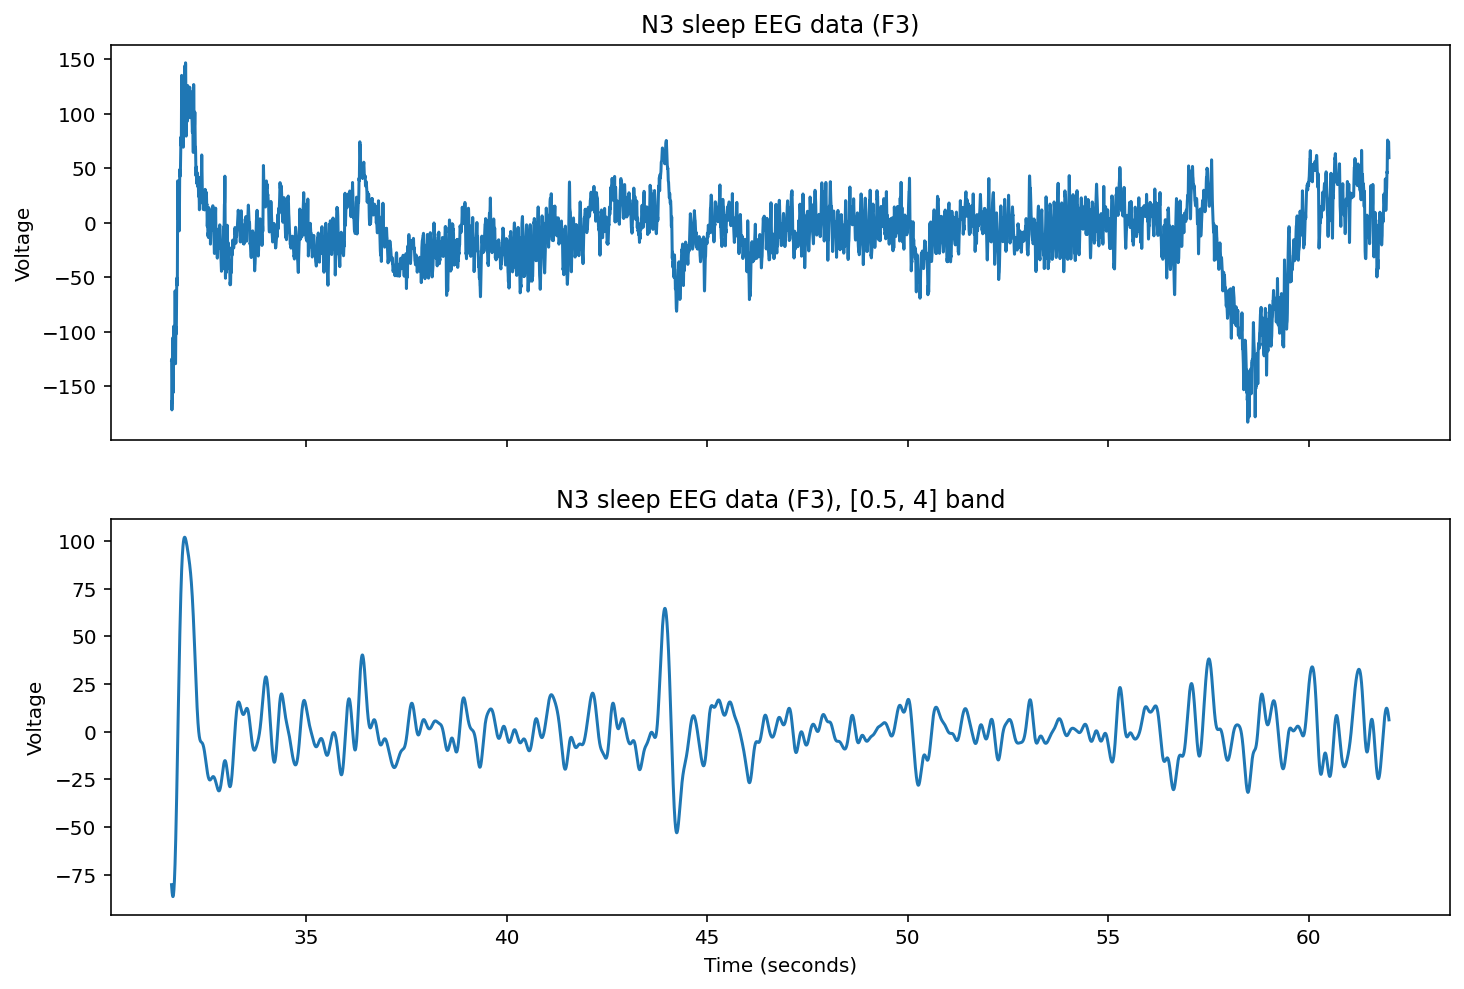

In [30]:
fig, ax = plt.subplots(2,1,figsize=(12, 8), sharex=True)

# Plot our raw data
ax[0].plot(timestamps,recording)
ax[0].set_ylabel('Voltage')
ax[0].set_title('N3 sleep EEG data (F3)')

# Plot the bandpassed data
ax[1].plot(timestamps,bandpassed)
ax[1].set_ylabel('Voltage')

# Let's programmatically set the title here, using {} format
ax[1].set_title('N3 sleep EEG data (F3), {} band' .format(filter_limits))

plt.xlabel('Time (seconds)')
plt.show()

## Frequency analysis with simple sine waves

Let's first generate a sine wave. We'll then generate a second sine wave and add these together to understand what a fourier transform of this data would look like. **Sine waves** are defined by their frequency, ampltitude, and and phase.

In [32]:
f = 1024 # Sampling frequency
dur = 1 # 10 seconds of signal -- SORRY NOW IT'S 1 SECOND!!
freq = 7 # 7 Hz signal
freq2 = 130 # 130 Hz signal

t = np.arange(0, dur, 1/f) # Generate a time vector

sig1 = np.sin(2 * np.pi * freq * t) # Generate a sine wave
sig1 = 2 * sig1; # Increase the power of signal 1

sig2 = np.sin(2 * np.pi * freq2 * t) # Generate another sine wave

Plot our sine waves:

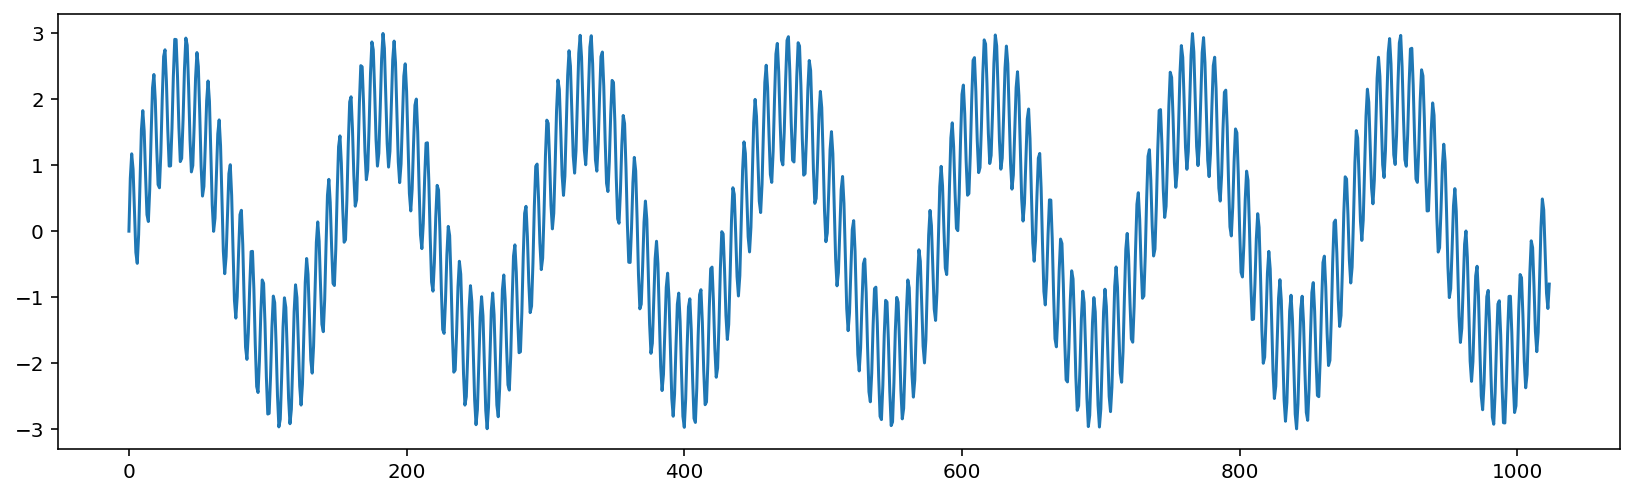

In [33]:
# Add signal 1 & 2
combined_signal = sig1+sig2

# Plot
plt.subplots(1,1,figsize=(14,4))
plt.plot(combined_signal)
plt.show()

Below, we'll calculate the **Fourier Transform** using the fast fourier transform package from numpy. The fft (developed by Tukey -- same Tukey as the statistics Tukey -- in 1965) implements a _discrete_ Fourier transform for a digital signal.

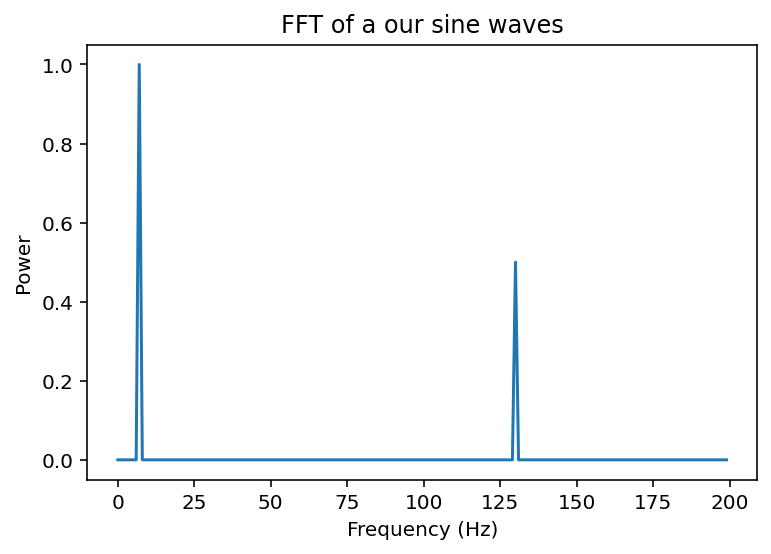

In [35]:
# Calculate the fourier transform of complex signal
fourier = np.fft.fft(combined_signal)/len(t) # Compute the fft, normalized by time

# Find frequency values for the x axis
nyq = f/2 # Determine the nyquist frequency

# Create freq bins for plotting by creating a vector from 0 to nyquist
# with as many points as in fft
fx_bins = np.linspace(0,nyq,int(np.floor(len(sig1)/2))+1)

# Plotting up to 200 Hz
plt.plot(fx_bins[0:200],abs(fourier[0:200])) # Plot a select range of frequencies
plt.ylabel('Power')
plt.xlabel('Frequency (Hz)')
plt.title('FFT of a our sine waves')
plt.show()

**Note**: As Pascal Wallisch & Eric Nylen have written: "Frequency space is a place of _magic and wonder_." The Fourier transform of a time series usually involves complex numbers with imaginary parts. If we plot the Fourier transform itself by typing `plt.plot(fourier)`, it will yield a funky plot. That’s because the complex numbers represent both magnitude and phase at once, but we are _only interested in amplitude or power_ at this point, which is why we plotted only the absolute values above. Also, if you type `plt.plot(abs(fourier))`, you will get a plot of all the magnitudes, but note that it is mirror-symmetric in the middle—it repeats after half the sampling rate.

##  Calculate the power spectrum of our EEG data

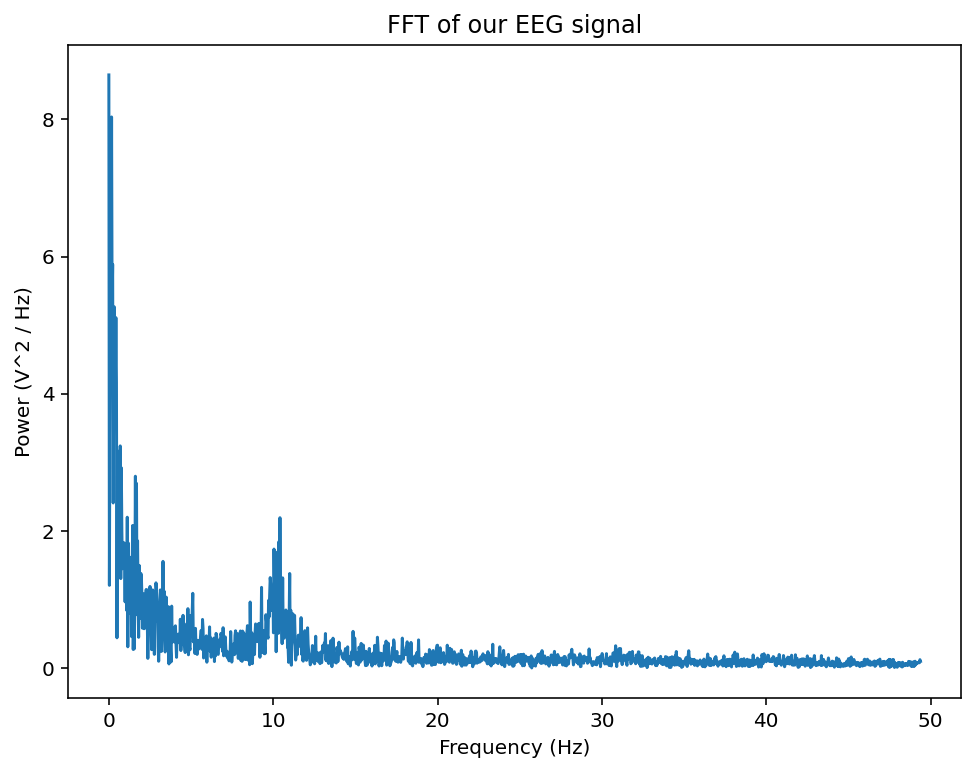

In [37]:
# Calculate the fourier transform of complex signal
ft = np.fft.fft(recording)/len(timestamps) # Compute the fft, normalized by time

# Find frequency values for the x axis
nyq = sampling_freq/2 # Determine the nyquist frequency

# Create freq bins for plotting by creating a vector from 0 to nyquist, with as many points as in fft
fx_bins = np.linspace(0,nyq,int(np.floor(len(recording)/2))+1)

# plotting up to 200 Hz
plt.figure(figsize=(8, 6))
plt.plot(fx_bins[0:1500],abs(ft[0:1500]))
plt.ylabel('Power (V^2 / Hz)')
plt.xlabel('Frequency (Hz)')
plt.title('FFT of our EEG signal')
plt.show()

Hmm, this is interesting but a bit noisy. Maybe we need a method that is _better_ than the simple fast fourier transform for this type of data. Thankfully, there's a way to smooth out our fft without losing too much information. 

The most widely-used method to do that is [**Welch's Method**](https://en.wikipedia.org/wiki/Welch%27s_method), which consists in averaging consecutive Fourier transform of small windows of the signal, with or without overlapping. Basically, we calculate the fft of a signal across a few sliding windows, and then calculate the mean PSD from all the sliding windows.

The `freqs` vector contains the x-axis (frequency bins) and the `psd` vector contains the y-axis (power spectral density). The units of the power spectral density, when working with EEG data, is usually $\mu$V^2 per Hz.

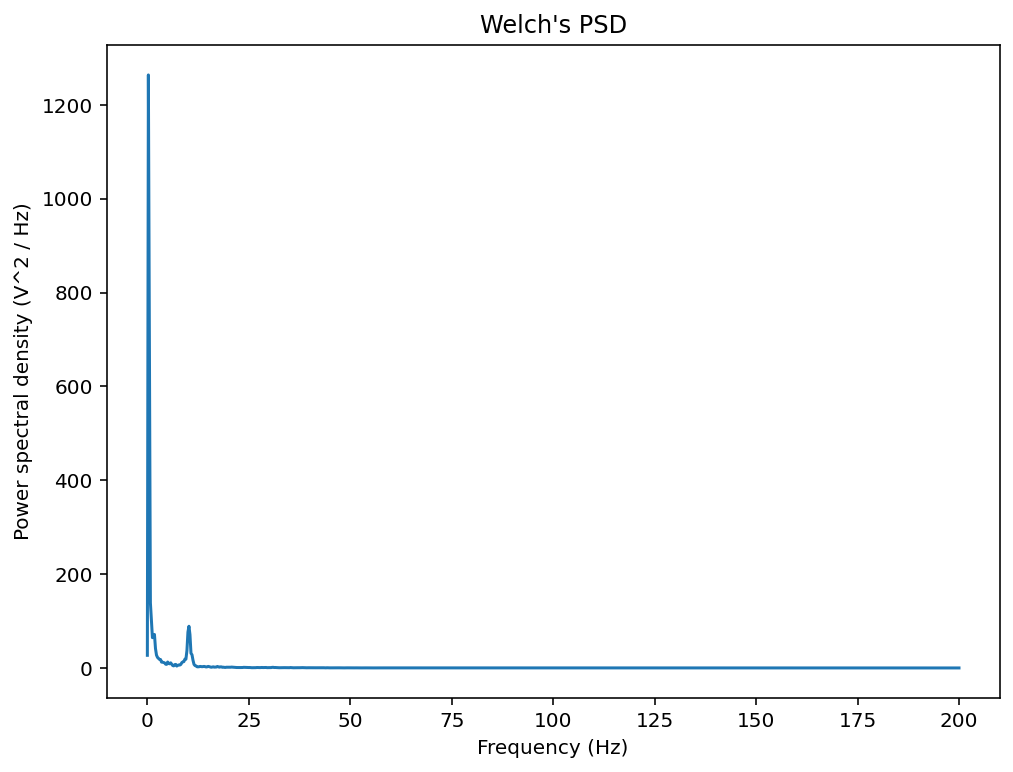

In [38]:
# Define sliding window length (4 seconds, which will give us 2 full cycles at 0.5 Hz)
win = 4 * sampling_freq
freqs, psd = signal.welch(recording, sampling_freq, nperseg=win)

# Plot the power spectrum
plt.figure(figsize=(8, 6))
plt.plot(freqs, psd)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.title("Welch's PSD")
plt.show()

As a final step, we can plot a spectrogram of our signal. This is a common way to visualize EEG signals. The spectrogram results from doing the FFT on the snippet of the signal that falls into a “window,” plotting the frequency content in the window, then moving the window in time and plotting the frequency content again (and again) until the window has moved across the entire signal.

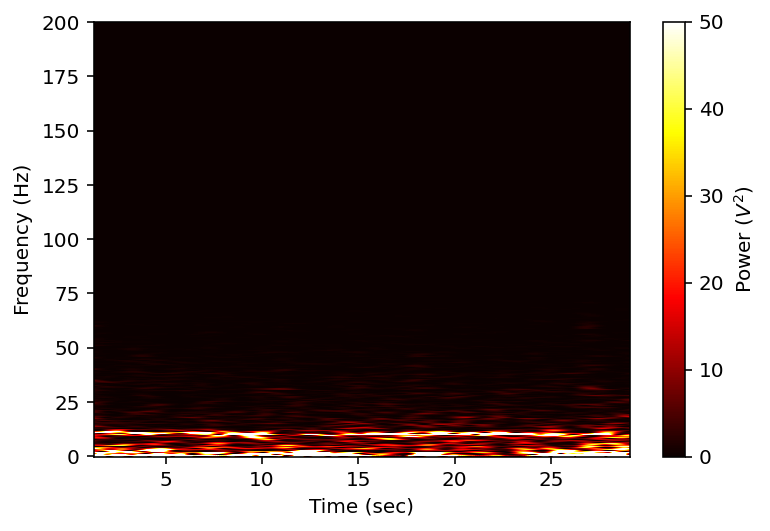

In [46]:
window_size = 1024; # Define the number of elements in our binning window
wind = np.hanning(window_size) # Create a "hanning" window with our given size

# Create the spectrogram and plot

fig = plt.figure() 
f, tt, Sxx = signal.spectrogram(recording,sampling_freq,wind,len(wind),len(wind)-1)

# You can change cmap if you want
plt.pcolormesh(tt,f,Sxx,cmap='hot',vmax=50) #14
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (sec)')
#plt.ylim([0,20])
cbar = plt.colorbar()
cbar.ax.set_ylabel('Power ($V^2$)')
plt.show()

Option #2, using specgram:

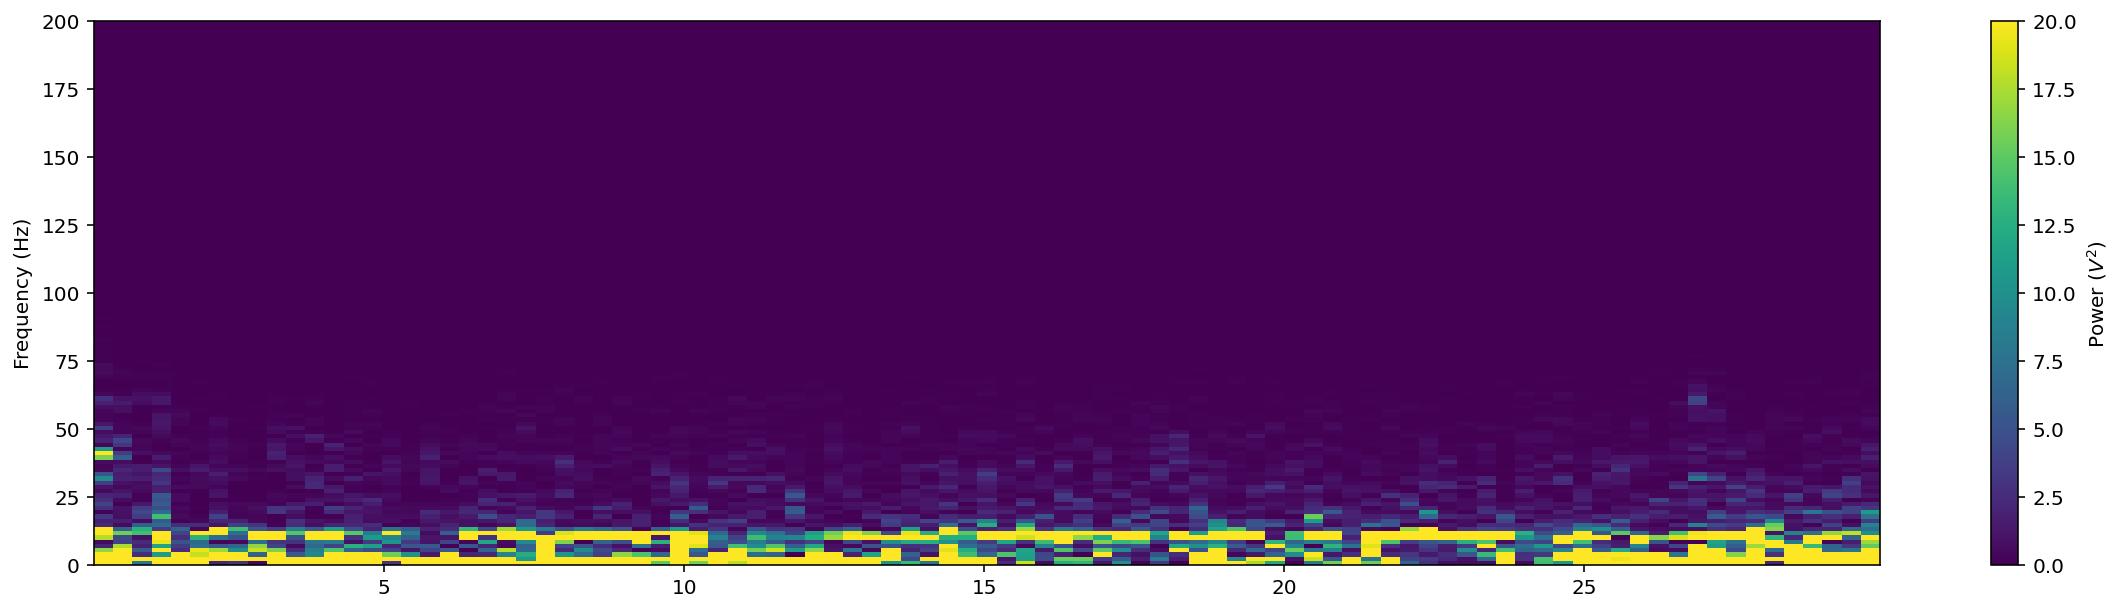

In [45]:
vmax = 20 # change the max value on your spectogram -- you may need to adjust this

plt.figure(figsize=(20,5))
plt.specgram(recording, Fs=sampling_freq,scale='linear',vmax=vmax)
plt.ylabel('Frequency (Hz)')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Power ($V^2$)')
plt.show()